In [25]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# create state space and initial state probabilities

states = ['sleeping', 'eating', 'pooping']
pi = [0.35, 0.35, 0.3]
state_space = pd.Series(pi, index=states, name='states')
print(state_space)
print(state_space.sum())

sleeping    0.35
eating      0.35
pooping     0.30
Name: states, dtype: float64
1.0


In [26]:
q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.4, 0.2, 0.4]
q_df.loc[states[1]] = [0.45, 0.45, 0.1]
q_df.loc[states[2]] = [0.45, 0.25, .3]

print(q_df)

q = q_df.values
print('\n', q, q.shape, '\n')
print(q_df.sum(axis=1))

         sleeping eating pooping
sleeping      0.4    0.2     0.4
eating       0.45   0.45     0.1
pooping      0.45   0.25     0.3

 [[0.4 0.2 0.4]
 [0.45 0.45 0.1]
 [0.45 0.25 0.3]] (3, 3) 

sleeping    1.0
eating      1.0
pooping     1.0
dtype: float64


# Networkx creates Graphs that consist of nodes and edges. In our toy example the dog's possible states are the nodes and the edges are the lines that connect the nodes. The transition probabilities are the weights. They represent the probability of transitioning to a state given the current state.

### Something to note is networkx deals primarily with dictionary objects. With that said, we need to create a dictionary object that holds our edges and their weights.

In [27]:
from pprint import pprint 

# create a function that maps transition probability dataframe 
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

{('eating', 'eating'): 0.45,
 ('eating', 'pooping'): 0.1,
 ('eating', 'sleeping'): 0.45,
 ('pooping', 'eating'): 0.25,
 ('pooping', 'pooping'): 0.3,
 ('pooping', 'sleeping'): 0.45,
 ('sleeping', 'eating'): 0.2,
 ('sleeping', 'pooping'): 0.4,
 ('sleeping', 'sleeping'): 0.4}


### Now we can create the graph. To visualize a Markov model we need to use nx.MultiDiGraph(). A multidigraph is simply a directed graph which can have multiple arcs such that a single node can be both the origin and destination. 

In the following code, we create the graph object, add our nodes, edges, and labels, then draw a bad networkx plot while outputting our graph to a dot file. 

In [28]:
state_space

sleeping    0.35
eating      0.35
pooping     0.30
Name: states, dtype: float64

Nodes:
['sleeping', 'eating', 'pooping']

Edges:
OutMultiEdgeDataView([('sleeping', 'sleeping', {'weight': 0.4, 'label': 0.4}), ('sleeping', 'eating', {'weight': 0.2, 'label': 0.2}), ('sleeping', 'pooping', {'weight': 0.4, 'label': 0.4}), ('eating', 'sleeping', {'weight': 0.45, 'label': 0.45}), ('eating', 'eating', {'weight': 0.45, 'label': 0.45}), ('eating', 'pooping', {'weight': 0.1, 'label': 0.1}), ('pooping', 'sleeping', {'weight': 0.45, 'label': 0.45}), ('pooping', 'eating', {'weight': 0.25, 'label': 0.25}), ('pooping', 'pooping', {'weight': 0.3, 'label': 0.3})])


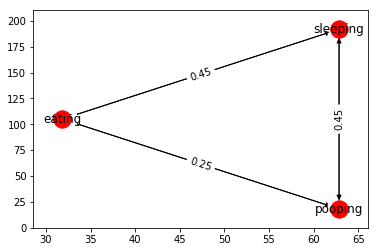

In [29]:
# create graph object
G = nx.MultiDiGraph()
# nodes correspond to states
G.add_nodes_from(states)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
print(f'Edges:')
pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_markov.dot')

In [31]:
hidden_states = ['healthy', 'sick']
pi = [0.5, 0.5]
state_space = pd.Series(pi, index=hidden_states, name='states')
print(state_space)
print('\n', state_space.sum())

healthy    0.5
sick       0.5
Name: states, dtype: float64

 1.0


In [32]:
# create hidden transition matrix
# a or alpha 
#   = transition probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states

a_df = pd.DataFrame(columns=hidden_states, index=hidden_states)
a_df.loc[hidden_states[0]] = [0.7, 0.3]
a_df.loc[hidden_states[1]] = [0.4, 0.6]

print(a_df)

a = a_df.values
print('\n', a, a.shape, '\n')
print(a_df.sum(axis=1))

        healthy sick
healthy     0.7  0.3
sick        0.4  0.6

 [[0.7 0.3]
 [0.4 0.6]] (2, 2) 

healthy    1.0
sick       1.0
dtype: float64


In [33]:
# create matrix of observation (emission) probabilities
# b or beta = observation probabilities given state
# matrix is size (M x O) where M is number of states 
# and O is number of different possible observations

observable_states = states

b_df = pd.DataFrame(columns=observable_states, index=hidden_states)
b_df.loc[hidden_states[0]] = [0.2, 0.6, 0.2]
b_df.loc[hidden_states[1]] = [0.4, 0.1, 0.5]

print(b_df)

b = b_df.values
print('\n', b, b.shape, '\n')
print(b_df.sum(axis=1))

        sleeping eating pooping
healthy      0.2    0.6     0.2
sick         0.4    0.1     0.5

 [[0.2 0.6 0.2]
 [0.4 0.1 0.5]] (2, 3) 

healthy    1.0
sick       1.0
dtype: float64


In [34]:
# create graph edges and weights

hide_edges_wts = _get_markov_edges(a_df)
pprint(hide_edges_wts)

emit_edges_wts = _get_markov_edges(b_df)
pprint(emit_edges_wts)

{('healthy', 'healthy'): 0.7,
 ('healthy', 'sick'): 0.3,
 ('sick', 'healthy'): 0.4,
 ('sick', 'sick'): 0.6}
{('healthy', 'eating'): 0.6,
 ('healthy', 'pooping'): 0.2,
 ('healthy', 'sleeping'): 0.2,
 ('sick', 'eating'): 0.1,
 ('sick', 'pooping'): 0.5,
 ('sick', 'sleeping'): 0.4}


Nodes:
['healthy', 'sick']

Edges:
OutMultiEdgeDataView([('healthy', 'healthy', {'weight': 0.7, 'label': 0.7}), ('healthy', 'sick', {'weight': 0.3, 'label': 0.3}), ('healthy', 'sleeping', {'weight': 0.2, 'label': 0.2}), ('healthy', 'eating', {'weight': 0.6, 'label': 0.6}), ('healthy', 'pooping', {'weight': 0.2, 'label': 0.2}), ('sick', 'healthy', {'weight': 0.4, 'label': 0.4}), ('sick', 'sick', {'weight': 0.6, 'label': 0.6}), ('sick', 'sleeping', {'weight': 0.4, 'label': 0.4}), ('sick', 'eating', {'weight': 0.1, 'label': 0.1}), ('sick', 'pooping', {'weight': 0.5, 'label': 0.5})])


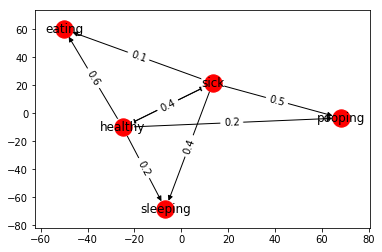

In [35]:
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(hidden_states)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent hidden probabilities
for k, v in hide_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

# edges represent emission probabilities
for k, v in emit_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
    
print(f'Edges:')
pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='neato')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
emit_edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=emit_edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_hidden_markov.dot')

In [36]:
# observation sequence of dog's behaviors
# observations are encoded numerically

obs_map = {'sleeping':0, 'eating':1, 'pooping':2}
obs = np.array([1,1,2,1,0,1,2,1,0,2,2,0,1,0,1])

inv_obs_map = dict((v,k) for k, v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(obs)]

print( pd.DataFrame(np.column_stack([obs, obs_seq]), 
                columns=['Obs_code', 'Obs_seq']) )

   Obs_code   Obs_seq
0         1    eating
1         1    eating
2         2   pooping
3         1    eating
4         0  sleeping
5         1    eating
6         2   pooping
7         1    eating
8         0  sleeping
9         2   pooping
10        2   pooping
11        0  sleeping
12        1    eating
13        0  sleeping
14        1    eating


In [37]:
# observation sequence of dog's behaviors
# observations are encoded numerically

obs_map = {'sleeping':0, 'eating':1, 'pooping':2}
obs = np.array([1,1,2,1,0,1,2,1,0,2,2,0,1,0,1])

inv_obs_map = dict((v,k) for k, v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(obs)]

print( pd.DataFrame(np.column_stack([obs, obs_seq]), 
                columns=['Obs_code', 'Obs_seq']) )

   Obs_code   Obs_seq
0         1    eating
1         1    eating
2         2   pooping
3         1    eating
4         0  sleeping
5         1    eating
6         2   pooping
7         1    eating
8         0  sleeping
9         2   pooping
10        2   pooping
11        0  sleeping
12        1    eating
13        0  sleeping
14        1    eating


In [43]:
# define Viterbi algorithm for shortest path
# code adapted from Stephen Marsland's, Machine Learning An Algorthmic Perspective, Vol. 2
# https://github.com/alexsosn/MarslandMLAlgo/blob/master/Ch16/HMM.py

def viterbi(pi, a, b, obs):
    
    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]
    
    # init blank path
    path = np.zeros(T)
    # delta --> highest probability of any path that reaches state i
    delta = np.zeros((nStates, T))
    # phi --> argmax by time step for each state
    phi = np.zeros((nStates, T))
    
    # init delta and phi 
    delta[:, 0] = pi * b[:, obs[0]]
    phi[:, 0] = 0

    print('\nStart Walk Forward\n')    
    # the forward algorithm extension
    for t in range(1, T):
        for s in range(nStates):
            delta[s, t] = np.max(delta[:, t-1] * a[:, s]) * b[s, obs[t]] 
            phi[s, t] = np.argmax(delta[:, t-1] * a[:, s])
            print('s={s} and t={t}: phi[{s}, {t}] = {phi}'.format(s=s, t=t, phi=phi[s, t]))
    
    # find optimal path
    print('-'*50)
    print('Start Backtrace\n')
    path[T-1] = np.argmax(delta[:, T-1])
    #p('init path\n    t={} path[{}-1]={}\n'.format(T-1, T, path[T-1]))
    for t in range(T-2, -1, -1):
        path[t] = phi[path[t+1],[t+1]]
        #p(' '*4 + 't={t}, path[{t}+1]={path}, [{t}+1]={i}'.format(t=t, path=path[t+1], i=[t+1]))
        print('path[{}] = {}'.format(t, path[t]))
        
    return path, delta, phi

path, delta, phi = viterbi(pi, a, b, obs)
print('\nsingle best state path: \n', path)
print('delta:\n', delta)
print('phi:\n', phi)


Start Walk Forward

s=0 and t=1: phi[0, 1] = 0.0
s=1 and t=1: phi[1, 1] = 0.0
s=0 and t=2: phi[0, 2] = 0.0
s=1 and t=2: phi[1, 2] = 0.0
s=0 and t=3: phi[0, 3] = 0.0
s=1 and t=3: phi[1, 3] = 1.0
s=0 and t=4: phi[0, 4] = 0.0
s=1 and t=4: phi[1, 4] = 0.0
s=0 and t=5: phi[0, 5] = 0.0
s=1 and t=5: phi[1, 5] = 1.0
s=0 and t=6: phi[0, 6] = 0.0
s=1 and t=6: phi[1, 6] = 0.0
s=0 and t=7: phi[0, 7] = 0.0
s=1 and t=7: phi[1, 7] = 1.0
s=0 and t=8: phi[0, 8] = 0.0
s=1 and t=8: phi[1, 8] = 0.0
s=0 and t=9: phi[0, 9] = 0.0
s=1 and t=9: phi[1, 9] = 1.0
s=0 and t=10: phi[0, 10] = 1.0
s=1 and t=10: phi[1, 10] = 1.0
s=0 and t=11: phi[0, 11] = 1.0
s=1 and t=11: phi[1, 11] = 1.0
s=0 and t=12: phi[0, 12] = 1.0
s=1 and t=12: phi[1, 12] = 1.0
s=0 and t=13: phi[0, 13] = 0.0
s=1 and t=13: phi[1, 13] = 0.0
s=0 and t=14: phi[0, 14] = 0.0
s=1 and t=14: phi[1, 14] = 1.0
--------------------------------------------------
Start Backtrace



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
state_map = {0:'healthy', 1:'sick'}
state_path = [state_map[v] for v in path]

(pd.DataFrame()
 .assign(Observation=obs_seq)
 .assign(Best_Path=state_path))

In [ ]:
import pandas as pd
import pandas_datareader.data as web
import sklearn.mixture as mix

import numpy as np
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns
import missingno as msno
from tqdm import tqdm
p=print
# get fed data

f1 = 'TEDRATE' # ted spread
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m

start = pd.to_datetime('2002-01-01')
end = pd.datetime.today()

mkt = 'SPY'
MKT = (web.DataReader([mkt], 'yahoo', start, end)['Adj Close']
       .rename(columns={mkt:mkt})
       .assign(sret=lambda x: np.log(x[mkt]/x[mkt].shift(1)))
       .dropna())

data = (web.DataReader([f1, f2, f3], 'fred', start, end)
        .join(MKT, how='inner')
        .dropna()
       )

p(data.head())

# gives us a quick visual inspection of the data
msno.matrix(data)


# code adapted from http://hmmlearn.readthedocs.io
# for sklearn 18.1

col = 'sret'
select = data.ix[:].dropna()

ft_cols = [f1, f2, f3, 'sret']
X = select[ft_cols].values

model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=select.index)
          .join(select, how='inner')
          .assign(mkt_cret=select.sret.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
p(states.head())

sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                   palette=scolor, aspect=1.31, size=12)
fg.map(plt.scatter, 'Date', mkt, alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SPY Regimes', fontsize=24, fontweight='demi')
fg.savefig('Hidden Markov (Mixture) Model_SPY Regimes.png')

In [1]:
# import python modules -- this cell needs to be run again if you make changes to any of the files
import matplotlib.pyplot as plt
import numpy as np

from helpers import show_model
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

In [9]:

model = HiddenMarkovModel(name="Example Model")
#Emission probality
sunny_emmission=DiscreteDistribution({'yes':0.1,'no':0.9})
#nodel
sunny_state=State(sunny_emmission,name='Sunny')


rainy_emmission=DiscreteDistribution({'yes':0.8,"no":0.2})
rainy_state=State(rainy_emmission,name="Rainy")

model.add_states([sunny_state,rainy_state])

In [10]:
# create edges for each possible state transition in the model
# equal probability of a sequence starting on either a rainy or sunny day
model.add_transition(model.start,sunny_state,0.5)
model.add_transition(model.start,rainy_state,0.5)

#Transition probalities
model.add_transition(sunny_state,sunny_state,0.8)
model.add_transition(sunny_state,rainy_state,0.2)

model.add_transition(rainy_state,rainy_state,0.6)
model.add_transition(rainy_state,sunny_state,0.4)

# finally, call the .bake() method to finalize the model
model.bake()

In [23]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Users\Sarthak\AppData\Local\Continuum\anaconda3\Library\bin\graphviz-2.38'


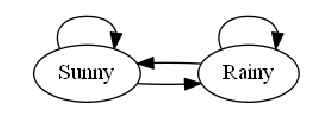

In [24]:
show_model(model, figsize=(5, 5), filename="example.png", overwrite=True, show_ends=False)

In [6]:
model.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "str",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "yes" : 0.8,
                 "no" : 0.2
             }
         ],
         "frozen" : false
     },
     "name" : "Rainy",
     "weight" : 1.0
 }, {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "str",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "yes" : 0.1,
                 "no" : 0.9
             }
         ],
         "frozen" : false
     },
     "name" : "Sunny",
     "weight" : 1.0
 }, {
     "class" : "State",
     "distribution" : null,
     "name" : "Example model-start",
     "weight" : 1.0
 }, {
     "class" : "State",
     "distribution" : null,
     "name" : "Example model-end",
     "weight" : 1.0
 }]

In [7]:
model.dense_transition_matrix

<function HiddenMarkovModel.dense_transition_matrix>

In [11]:
column_order = ["Example Model-start", "Sunny", "Rainy", "Example Model-end"]  # Override the Pomegranate default order
column_names = [s.name for s in model.states]
order_index = [column_names.index(c) for c in column_order]

# re-order the rows/columns to match the specified column order
transitions = model.dense_transition_matrix()[:, order_index][order_index, :]
print("The state transition matrix, P(Xt|Xt-1):\n")
print(transitions)
print("\nThe transition probability from Rainy to Sunny is {:.0f}%".format(100 * transitions[2, 1]))

The state transition matrix, P(Xt|Xt-1):

[[0.  0.5 0.5 0. ]
 [0.  0.8 0.2 0. ]
 [0.  0.4 0.6 0. ]
 [0.  0.  0.  0. ]]

The transition probability from Rainy to Sunny is 40%


In [15]:
# TODO: input a sequence of 'yes'/'no' values in the list below for testing
observations = ['yes', 'no', 'yes','no','yes']

# TODO: use model.viterbi to find the sequence likelihood & the most likely path
viterbi_likelihood, viterbi_path = model.viterbi(observations)

print("The most likely weather sequence to have generated " + \
      "these observations is {} at {:.2f}%."
      .format([s[1].name for s in viterbi_path[1:]], np.exp(viterbi_likelihood)*100)
)

The most likely weather sequence to have generated these observations is ['Rainy', 'Sunny', 'Sunny', 'Sunny', 'Rainy'] at 0.13%.


In [22]:
from itertools import product

observations = ['no', 'no', 'yes','no']#,'yes']

p = {'Sunny': {'Sunny': np.log(.8), 'Rainy': np.log(.2)}, 'Rainy': {'Sunny': np.log(.4), 'Rainy': np.log(.6)}}
e = {'Sunny': {'yes': np.log(.1), 'no': np.log(.9)}, 'Rainy':{'yes':np.log(.8), 'no':np.log(.2)}}
o = observations
k = []
vprob = np.exp(model.viterbi(o)[0])
print("The likelihood of observing {} if the weather sequence is...".format(o))
for s in product(*[['Sunny', 'Rainy']]*4):
    k.append(np.exp(np.log(.5)+e[s[0]][o[0]] + p[s[0]][s[1]] + e[s[1]][o[1]] + p[s[1]][s[2]] + e[s[2]][o[2]]))
    print("\t{} is {:.2f}% {}".format(s, 100 * k[-1], " <-- Viterbi path" if k[-1] == vprob else ""))
print("\nThe total likelihood of observing {} over all possible paths is {:.2f}%".format(o, 100*sum(k)))

The likelihood of observing ['no', 'no', 'yes', 'no'] if the weather sequence is...
	('Sunny', 'Sunny', 'Sunny', 'Sunny') is 2.59% 
	('Sunny', 'Sunny', 'Sunny', 'Rainy') is 2.59% 
	('Sunny', 'Sunny', 'Rainy', 'Sunny') is 5.18% 
	('Sunny', 'Sunny', 'Rainy', 'Rainy') is 5.18% 
	('Sunny', 'Rainy', 'Sunny', 'Sunny') is 0.07% 
	('Sunny', 'Rainy', 'Sunny', 'Rainy') is 0.07% 
	('Sunny', 'Rainy', 'Rainy', 'Sunny') is 0.86% 
	('Sunny', 'Rainy', 'Rainy', 'Rainy') is 0.86% 
	('Rainy', 'Sunny', 'Sunny', 'Sunny') is 0.29% 
	('Rainy', 'Sunny', 'Sunny', 'Rainy') is 0.29% 
	('Rainy', 'Sunny', 'Rainy', 'Sunny') is 0.58% 
	('Rainy', 'Sunny', 'Rainy', 'Rainy') is 0.58% 
	('Rainy', 'Rainy', 'Sunny', 'Sunny') is 0.05% 
	('Rainy', 'Rainy', 'Sunny', 'Rainy') is 0.05% 
	('Rainy', 'Rainy', 'Rainy', 'Sunny') is 0.58% 
	('Rainy', 'Rainy', 'Rainy', 'Rainy') is 0.58% 

The total likelihood of observing ['no', 'no', 'yes', 'no'] over all possible paths is 20.40%
